In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [200]:
print(os.getcwd())

/home/electro


In [201]:
# 1. Veri Yükleme ve Ön İşleme
df = pd.read_csv('wine_data_duzenli.csv', skipinitialspace=True)
df [:5]

,Class,Alcohol,Malic_Acid,Ash,Alcaline_of_Ash,Magnesium,Total_phenols,Flavanoids,Non_flvanoid_phenols,Proanthocyanins,Color_Intensity,Hue,OD280/OD315 of,Proline,Unnamed: 14,Unnamed: 15
0,1,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,NaN,NaN
1,1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,NaN,NaN
2,1,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,NaN,NaN
3,1,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,NaN,NaN
4,1,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,NaN,NaN


In [202]:
df = df.dropna(axis=1, how='all')  # Boş sütunları silme
print(df.isnull().sum())
#df

Class                   0
Alcohol                 0
Malic_Acid              2
Ash                     1
Alcaline_of_Ash         0
Magnesium               0
Total_phenols           0
Flavanoids              0
Non_flvanoid_phenols    0
Proanthocyanins         0
Color_Intensity         1
Hue                     0
OD280/OD315 of          0
Proline                 2
dtype: int64


In [203]:
eksik_veriler = df.pivot_table(index="Class", aggfunc=lambda x: x.isnull().sum())
# Sonuçları yazdır
print(eksik_veriler)


       Alcaline_of_Ash  Alcohol  Ash  Color_Intensity  Flavanoids  Hue  \
Class                                                                    
1                    0        0    0                0           0    0   
2                    0        0    0                0           0    0   
3                    0        0    1                1           0    0   

       Magnesium  Malic_Acid  Non_flvanoid_phenols  OD280/OD315 of  \
Class                                                                
1              0           0                     0               0   
2              0           0                     0               0   
3              0           2                     0               0   

       Proanthocyanins  Proline   Total_phenols  
Class                                            
1                    0         0              0  
2                    0         0              0  
3                    0         2              0  


In [204]:
# Class sütununun kategori olduğunu belirleyelim
df["Class"] = df["Class"].astype("category")

# Class değerlerine göre gruplama yaparak her grup için ortalama, medyan ve mod hesaplayalım
summary_tables = {}
selected_columns = ["Proline " , "Malic_Acid", "Ash", "Color_Intensity"]  # Sadece bu sütunlara bak

for class_value, group in df.groupby("Class"):
    numeric_columns = group[selected_columns].columns  # Sadece seçili sütunları al
    
    # Ortalama, medyan ve mod hesapla
    mean_values = group[numeric_columns].mean()
    median_values = group[numeric_columns].median()
    mode_values = group[numeric_columns].mode().iloc[0]  # Mod birden fazla olabilir, ilkini al

    # Sonuçları dfFrame olarak sakla
    summary_table = pd.DataFrame({
        "Ortalama (Mean)": mean_values,
        "Medyan (Median)": median_values,
        "Mod (Mode)": mode_values
    })

    # Sınıf bazlı tablolara ekle
    summary_tables[class_value] = summary_table

    # Sonuçları ekrana yazdır
    print(f"\n Class {class_value} İçin Özellikler Tablosu:\n")
    print(summary_table)


 Class 1 İçin Özellikler Tablosu:

                 Ortalama (Mean)  Medyan (Median)  Mod (Mode)
Proline              1115.711864          1095.00     1035.00
Malic_Acid              2.010678             1.77        1.73
Ash                     2.455593             2.44        2.36
Color_Intensity         5.528305             5.40        5.10

 Class 2 İçin Özellikler Tablosu:

                 Ortalama (Mean)  Medyan (Median)  Mod (Mode)
Proline               519.507042           495.00      450.00
Malic_Acid              1.932676             1.61        1.51
Ash                     2.244789             2.24        1.92
Color_Intensity         3.086620             2.90        2.60

 Class 3 İçin Özellikler Tablosu:

                 Ortalama (Mean)  Medyan (Median)  Mod (Mode)
Proline               633.804348          630.000      480.00
Malic_Acid              3.376739            3.265        3.03
Ash                     2.433617            2.380        2.48
Color_Intensity         

/tmp/ipykernel_2719/3104586428.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for class_value, group in df.groupby("Class"):


In [205]:
class_3_df = df[df['Class'] == 3]

malic_acid_mean_class_3 = class_3_df['Malic_Acid'].mean()
ash_mean_class_3 = class_3_df['Ash'].mean()
proline_mean_class_3 = class_3_df['Proline '].mean()
color_mean_class_3 = class_3_df['Color_Intensity'].mean()


df.loc[df['Class'] == 3, 'Malic_Acid'] = df.loc[df['Class'] == 3, 'Malic_Acid'].fillna(malic_acid_mean_class_3)
df.loc[df['Class'] == 3, 'Ash'] = df.loc[df['Class'] == 3, 'Ash'].fillna(ash_mean_class_3)
df.loc[df['Class'] == 3, 'Proline '] = df.loc[df['Class'] == 3, 'Proline '].fillna(proline_mean_class_3)
df.loc[df['Class'] == 3, 'Color_Intensity'] = df.loc[df['Class'] == 3, 'Color_Intensity'].fillna(color_mean_class_3)


print(df[df['Class'] == 3][['Malic_Acid', 'Ash','Proline ','Color_Intensity']])


df.to_csv("wine_data_updated.csv", index=False)

     Malic_Acid       Ash    Proline   Color_Intensity
130    1.350000  2.320000  630.000000         4.100000
131    2.990000  2.400000  530.000000         5.400000
132    2.310000  2.400000  560.000000         5.700000
133    3.550000  2.360000  600.000000         5.000000
134    3.376739  2.250000  650.000000         5.450000
135    2.460000  2.200000  695.000000         7.100000
136    4.720000  2.540000  720.000000         3.850000
137    5.510000  2.640000  515.000000         5.000000
138    3.590000  2.190000  580.000000         5.700000
139    2.960000  2.610000  590.000000         4.920000
140    2.810000  2.700000  600.000000         4.600000
141    2.560000  2.350000  780.000000         5.600000
142    3.170000  2.720000  520.000000         4.350000
143    4.950000  2.350000  550.000000         4.400000
144    3.880000  2.200000  855.000000         8.210000
145    3.570000  2.150000  830.000000         4.000000
146    5.040000  2.230000  415.000000         4.900000
147    4.6

In [206]:
#df = pd.read_csv("wine_df_duzenli.csv")

df.columns = df.columns.str.strip()

columns = [
    "Alcohol", "Malic_Acid", "Ash", "Alcaline_of_Ash", "Magnesium",
    "Total_phenols", "Flavanoids", "Non_flvanoid_phenols", "Proanthocyanins",
    "Color_Intensity", "Hue", "OD280/OD315 of", "Proline"
]

outlier_indices = set()  

for column in columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    mean_value = df[column].mean()
    
    column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    outlier_indices.update(column_outliers.index)
    
    print(f"Sütun: {column}")
    print(f"Ortalama: {mean_value}")
    print("Aykırı değerler:")
    print(column_outliers[column], "\n")

clean_df = df.drop(index=outlier_indices)

clean_df.to_csv("wine_data_cleaned.csv", index=False)

print("Orijinal veri boyutu:", df.shape)
print("Temiz veri boyutu:", clean_df.shape)

df=clean_df

Sütun: Alcohol
Ortalama: 13.00061797752809
Aykırı değerler:
Series([], Name: Alcohol, dtype: float64) 

Sütun: Malic_Acid
Ortalama: 2.347940889106009
Aykırı değerler:
123    5.80
137    5.51
173    5.65
Name: Malic_Acid, dtype: float64 

Sütun: Ash
Ortalama: 2.3655821180970595
Aykırı değerler:
25     3.22
59     1.36
66     1.70
100    1.70
121    3.23
Name: Ash, dtype: float64 

Sütun: Alcaline_of_Ash
Ortalama: 19.376966292134835
Aykırı değerler:
73     30.0
121    28.5
127    28.5
160     0.0
Name: Alcaline_of_Ash, dtype: float64 

Sütun: Magnesium
Ortalama: 99.26011235955056
Aykırı değerler:
69     151.0
73     139.0
78     136.0
95     162.0
160      2.3
Name: Magnesium, dtype: float64 

Sütun: Total_phenols
Ortalama: 2.287359550561798
Aykırı değerler:
Series([], Name: Total_phenols, dtype: float64) 

Sütun: Flavanoids
Ortalama: 2.0269101123595505
Aykırı değerler:
Series([], Name: Flavanoids, dtype: float64) 

Sütun: Non_flvanoid_phenols
Ortalama: 0.36370786516853937
Aykırı değerle

In [207]:
#df_drop = df.dropna()  # Eksik satırları silme
#df_drop
df

,Class,Alcohol,Malic_Acid,Ash,Alcaline_of_Ash,Magnesium,Total_phenols,Flavanoids,Non_flvanoid_phenols,Proanthocyanins,Color_Intensity,Hue,OD280/OD315 of,Proline
0,1,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.640000,1.04,3.92,1065.0
1,1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.380000,1.05,3.40,1050.0
2,1,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.680000,1.03,3.17,1185.0
3,1,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.800000,0.86,3.45,1480.0
4,1,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.320000,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,3,12.77,2.39,2.28,19.5,86.0,1.39,0.51,0.48,0.64,7.009362,0.57,1.63,470.0
172,3,14.16,2.51,2.48,20.0,91.0,1.68,0.70,0.44,1.24,9.700000,0.62,1.71,660.0
174,3,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.300000,0.70,1.56,750.0
175,3,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.200000,0.59,1.56,835.0


                         Class   Alcohol  Malic_Acid       Ash  \
Class                 1.000000 -0.394699    0.458274 -0.094506   
Alcohol              -0.394699  1.000000    0.073884  0.203495   
Malic_Acid            0.458274  0.073884    1.000000  0.139307   
Ash                  -0.094506  0.203495    0.139307  1.000000   
Alcaline_of_Ash       0.573508 -0.387703    0.272207  0.277988   
Magnesium            -0.257713  0.426025    0.004145  0.416952   
Total_phenols        -0.763672  0.349034   -0.368215  0.141626   
Flavanoids           -0.883645  0.333723   -0.456292  0.092934   
Non_flvanoid_phenols  0.494770 -0.201176    0.298675  0.046225   
Proanthocyanins      -0.606814  0.238187   -0.234176  0.059585   
Color_Intensity       0.169922  0.562324    0.270130  0.188248   
Hue                  -0.630122  0.017813   -0.580311  0.014973   
OD280/OD315 of       -0.789389  0.130006   -0.391474  0.013078   
Proline              -0.646313  0.673861   -0.186606  0.276473   

         

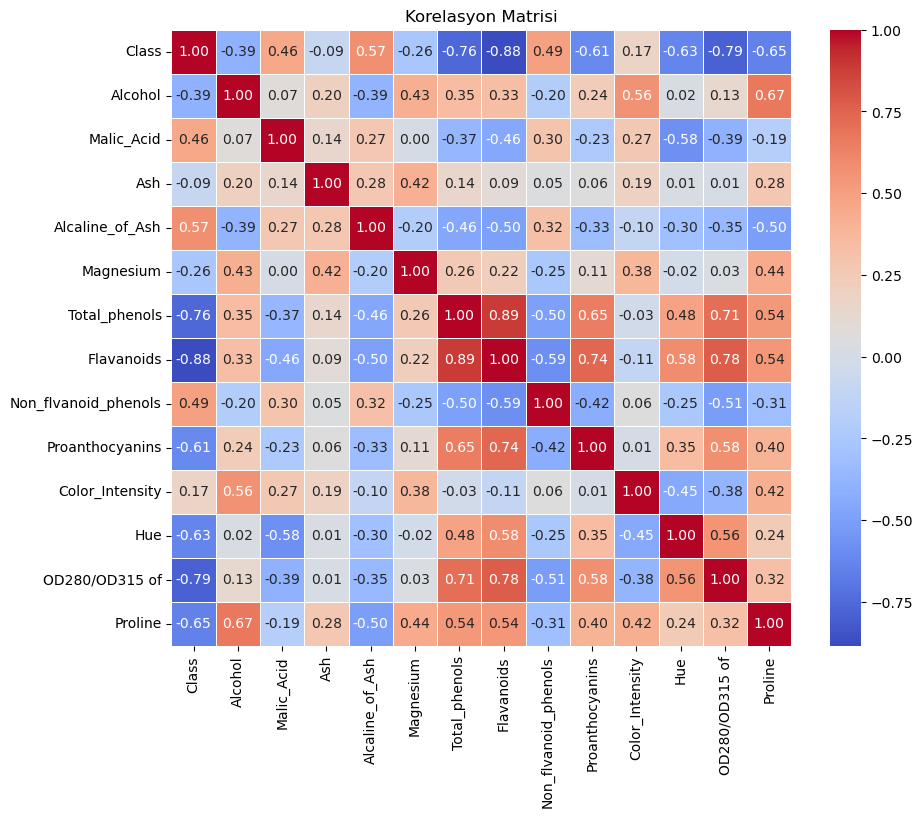

In [208]:
# Korelasyon matrisini hesapla (Pearson varsayılan)
corr_matrix = df.corr()

# Sonucu yazdır
print(corr_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korelasyon Matrisi")
plt.show()

In [209]:
# 2. Veri Normalizasyonu
X = df.drop('Class', axis=1) # Bağımlı değişkenin (Class) olduğu sütunu at ve geriye kalan öznitelikleri X'e kaydet
y = df['Class'] # Bağımlı değişken olarak Class'ı kullan 
scaler = MinMaxScaler() # Uygulana
X_scaled = scaler.fit_transform(X)
X=X_scaled

/tmp/ipykernel_2719/1176713713.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Ranking", y="Feature", data=feature_ranks, palette="viridis")


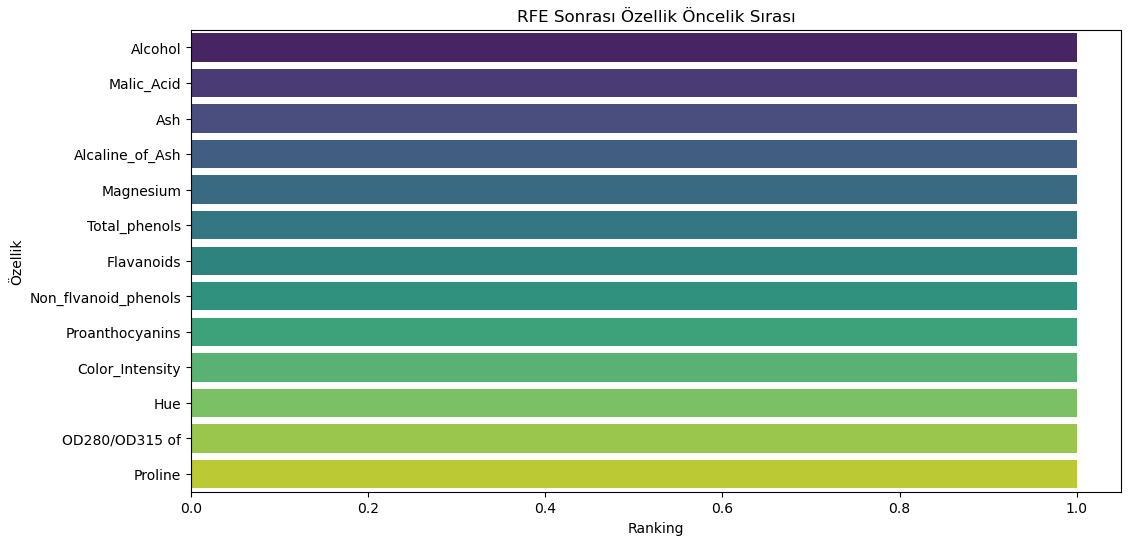

In [210]:
# X ve y'yi DataFrame olarak tanımlayın
X = df.drop("Class", axis=1)
y = df["Class"]

# Rastgele Orman Modeli Kullanarak RFE Uygulama
model = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFE(model, n_features_to_select=X.shape[1])  # Tüm özellikleri değerlendirmek için
selector.fit(X, y)

# Özelliklerin önem sırasını görselleştirme
feature_ranks = pd.DataFrame({
    "Feature": X.columns,
    "Ranking": selector.ranking_
}).sort_values(by="Ranking")

plt.figure(figsize=(12, 6))
sns.barplot(x="Ranking", y="Feature", data=feature_ranks, palette="viridis")
plt.ylabel("Özellik")
plt.title("RFE Sonrası Özellik Öncelik Sırası")
plt.show()


In [211]:
# 3. Train-Test Ayrımı
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=55)

In [217]:
# 4. Modeller ve Parametre Optimizasyonu
models = {
    'Logistic Regression': (LogisticRegression(), {'C': [0.1, 1, 10]}),
    'SVM': (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [None, 5, 10]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]})
}

results = {}
best_models = {}

for name, (model, params) in models.items():
    clf = GridSearchCV(model, params, cv=5)
    clf.fit(X_train, y_train)
    best_models[name] = clf.best_estimator_
    y_pred = clf.predict(X_test)
    results[name] = {
        'Best Params': clf.best_params_,
        'Train Accuracy': clf.best_score_,
        'Test Accuracy': accuracy_score(y_test, y_pred)
    }

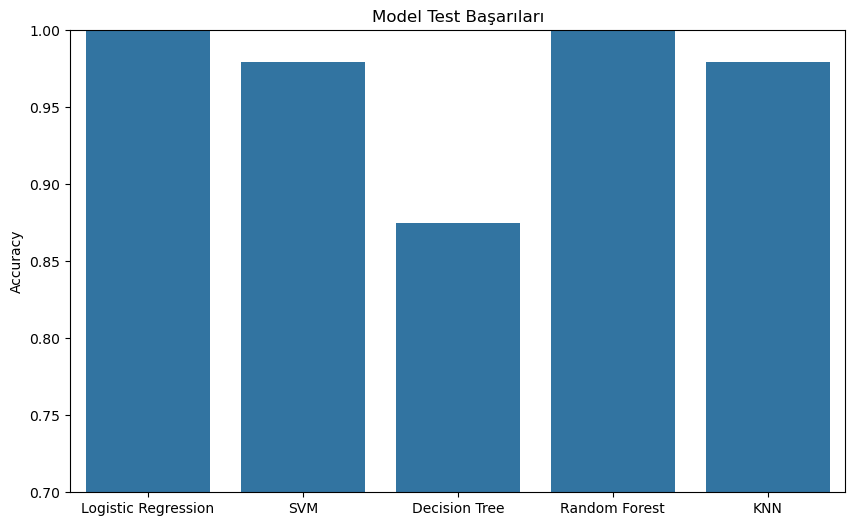

In [213]:
# 5. Sonuçları Görselleştirme
plt.figure(figsize=(10,6))
sns.barplot(x=list(results.keys()), y=[res['Test Accuracy'] for res in results.values()])
plt.title('Model Test Başarıları')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.show()

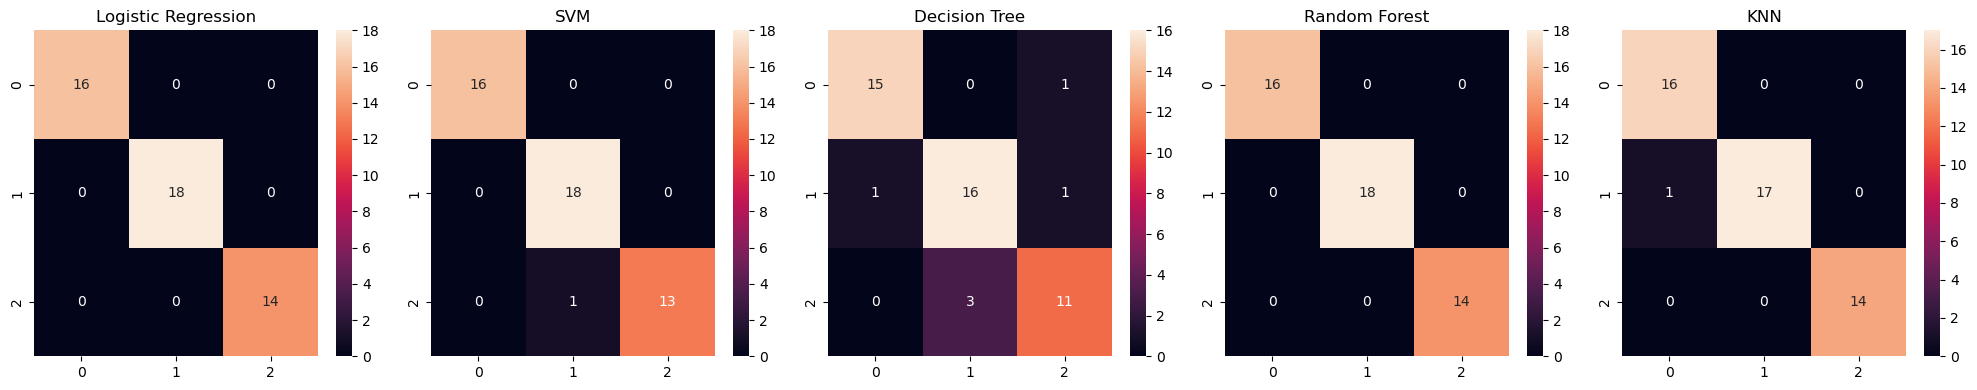

In [214]:
# 6. Confusion Matrix'ler
plt.figure(figsize=(20,4))
for i, (name, model) in enumerate(best_models.items(), 1):
    plt.subplot(1,5,i)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(name)
plt.tight_layout()
plt.show()

In [215]:
# 8. Detaylı Rapor
for name, res in results.items():
    print(f"\n{name}:")
    print(f"En iyi parametreler: {res['Best Params']}")
    print(f"Eğitim Accuracy: {res['Train Accuracy']:.3f}")
    print(f"Test Accuracy: {res['Test Accuracy']:.3f}")
    print(classification_report(y_test, best_models[name].predict(X_test)))


Logistic Regression:
En iyi parametreler: {'C': 10}
Eğitim Accuracy: 0.982
Test Accuracy: 1.000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        14

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48


SVM:
En iyi parametreler: {'C': 10, 'kernel': 'rbf'}
Eğitim Accuracy: 0.991
Test Accuracy: 0.979
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       0.95      1.00      0.97        18
           3       1.00      0.93      0.96        14

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48


Decision Tree:
En iyi parametreler: {'max_

NameError: name 'x' is not defined